In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import json

### Displacements and exponent prediction functions

In [2]:
def find_displacement(x_data, y_data, z_data, start_index=0):

    disps = np.sqrt(np.power(x_data-x_data[0],2) + np.power(y_data-y_data[0],2) + np.power(z_data-z_data[0],2))
    
    return disps 

def estimate_hurst(disps, time, window):
    
    h = np.array([])
    ht = np.array([])
    for i in range(int(window/2), len(disps)-int(1+window/2)):
        #sample of <window> points to calculate hurst exponent for
        inx = disps[(i-int(window/2)):(i+int(1+window/2))]
        #apply differencing and normalization on the data
        inx = np.array([(inx[1:]-inx[0:-1])/(np.amax(inx)-np.amin(inx))])
        test = model.predict(inx,verbose=0)
        h=np.append(h,test[0][0])
        ht = np.append(ht,time[i])
        
    return h,ht

### Downsampling functions

In [3]:
def downsample(data_input, down_int, start_index=0):
    
    data_out = data_input.iloc[start_index::down_int]
    return data_out


def dsample_est_hurst(data_in, ds_rate, window):
    """
    Args:
        data_in: pandas dataframe
        ds_rate: int, downsampling step size
    Returns:
        h_arr: 2D np array
        ht_arr: 2D np array
    """
    
    h_arr = np.empty((ds_rate,(len(data_in)//ds_rate)-(window+1)))
    ht_arr = np.empty((ds_rate,(len(data_in)//ds_rate)-(window+1)))
    
    for i in np.arange(ds_rate):
        
        downsampled_data = downsample(data_in, ds_rate, i)
        x = np.array(downsampled_data['Position X'])
        y = np.array(downsampled_data['Position Y'])
        z = np.array(downsampled_data['Position Z'])
        t = np.array(downsampled_data['Absolute Time'])
        displacements = find_displacement(x,y,z)
        h,ht = estimate_hurst(displacements, t, window)
        
        if len(h)>np.shape(h_arr)[1]:
            h=h[:-1]
            ht=ht[:-1]
            
        h_arr[i] = h
        ht_arr[i] = ht
        
    return h_arr,ht_arr


#def average_hurst(h_arr, ht_arr):
#    """
#    """
#    h_average_arr = np.mean(h_arr, axis=0)
#    ht_average_arr = np.mean(ht_arr, axis=0)
#    
#    return h_average_arr, ht_average_arr

In [4]:
def filter_data(data_in, max_step_size, window, restriction=-1):
    """
    Only keeps data for tracks that are long enough for hurst exponent estimation at a given downsampling step size.
    Args: 
        data_in: pandas dataframe, original data
        max_step_size: int, maximum downsampling step size
        window: int, size of rolling window for hurst component estimation
    Returns:
        filtered_data: pandas dataframe
    """
    tracks_to_keep = data_in.TrackID.value_counts().loc[lambda x: (x//max_step_size) > (window+1)].reset_index()['index']
    if restriction<len(tracks_to_keep):
        filtered_data = data_in[data_in['TrackID'].isin(tracks_to_keep[:restriction])]
    else:
        filtered_data = data_in[data_in['TrackID'].isin(tracks_to_keep)]
    return filtered_data

In [5]:
def get_h_values(filtered_data, step_size, window, restriction):
    """
    Args:
        filtered_data: pandas dataframe
    Returns 1D array of (mean) hurst exponent values for a given step size.
    """
    track_id_values = np.unique(filtered_data['TrackID'])
    
    h = np.array([])
    for tid in track_id_values:
        track_data = filtered_data[filtered_data['TrackID']==tid]
        h_arr, ht_arr = dsample_est_hurst(track_data, step_size, window)  
        # h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)  
        h = np.append(h, np.ravel(h_arr))
        
    return h

In [6]:
def get_h_dict(filtered_data, step_sizes, window, restriction):
    """
    """
    h_dict = {}
    
    for i, s in enumerate(step_sizes):
        h_arr = get_h_values(filtered_data, s, window, restriction)
        h_dict["{}".format(s)] = h_arr.tolist()
        
    return h_dict

def get_hist_h(h_dictionary, nbins):
    """
    """
    keys_list = list(h_dictionary)
    
    counts_all = np.empty((len(keys_list), nbins))
    bins_all = np.empty((len(keys_list), nbins+1))
    
    for i,key in enumerate(keys_list):
        counts, bins = np.histogram(h_dictionary[key], nbins, density=True)  # normalised so area under histogram is 1
        counts_all[i] = counts
        bins_all[i] = bins
    
    return counts_all, bins_all

def save_h_data(h_data, file_name, window, step_sizes, restriction):
    """
    """
    with open('h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'w') as file:
        file.write(json.dumps(h_data))
        
def get_dict_from_file(file_name, window, step_sizes, restriction):
    """
    Reads in dictionary of H values.
    """
    with open('h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
        h_dict = file.read()
    
    return json.loads(h_dict)

### Number of tracks available for given window size and step sizes 1, 2, ..., 10

In [7]:
def number_of_tracks(filenames, window, step_sizes=np.array([1,2,3,4,5,6,7,8,9,10]), pandas_df=True):
    """
    """
    ntracks_dict = {}
    
    for i, file in enumerate(filenames):
        data = pd.read_csv(file+'.csv')
        ntracks = np.empty((len(step_sizes)+1))
        ntracks[0] = len(np.unique(data['TrackID']))  # number of tracks in original data (independent of window, step size)
        for j, s in enumerate(step_sizes):
            filtered_data = filter_data(data, s, window)
            ntracks[j+1] = len(np.unique(filtered_data['TrackID']))  # number of tracks in filtered data
        ntracks_dict[file] = ntracks.tolist()
    
    if not pandas_df:
        return ntracks_dict
    
    else:
        column_labels = np.array(['original'])
        column_labels = np.append(column_labels, step_sizes.astype(str))
        df = pd.DataFrame.from_dict(ntracks_dict, orient='index', columns=column_labels)
        return df.apply(pd.to_numeric, downcast='integer')

In [8]:
window = 20

filenames = np.array(['Control_frame001-200',
                      'Control_frame200-400',
                      'Control_frame400-600',
                      'Control_frame600-800',
                      'Control_frame800-1000',
                      'Control_frame1000-1200',
                      'LanB1_frame001-200',
                      'LanB1_frame200-400',
                      'LanB1_frame400-600',
                      'LanB1_frame600-800',
                      'LanB1_frame800-1000',
                      'LanB1_frame1000-1200',
                      'defLanB1_300817_frame200-400',
                      'defLanB1_300817_frame400-600'])

print('for a window size of {}:'.format(window))
number_of_tracks(filenames, window)

for a window size of 20:


,original,1,2,3,4,5,6,7,8,9,10
Control_frame001-200,1806,1305,589,299,153,94,50,33,24,13,0
Control_frame200-400,1468,1207,697,380,235,142,99,73,55,34,0
Control_frame400-600,2172,1905,1093,651,402,285,214,152,112,77,0
Control_frame600-800,2117,1905,1096,685,469,340,235,174,139,91,0
Control_frame800-1000,1725,1602,1018,661,488,337,271,203,148,106,0
Control_frame1000-1200,1624,1512,1039,664,457,320,248,202,160,133,0
LanB1_frame001-200,4793,1238,481,240,130,79,53,35,22,13,0
LanB1_frame200-400,7239,1682,756,414,256,167,113,79,52,35,0
LanB1_frame400-600,3091,971,554,369,267,184,136,103,79,57,0
LanB1_frame600-800,5046,1502,869,594,440,327,266,219,172,142,0


### Main

In [9]:
#load neural network model
model = tf.keras.models.load_model("model3dense_n{}.h5".format(window))

In [10]:
step_sizes = [1,2,3,4,5]
restriction = -1

filenames = ['Control_frame200-400', 'LanB1_frame200-400']

# iterate over data files and save H dictionary 
for i, file in enumerate(filenames):
    print('opened file {}'.format(file))
    data = pd.read_csv(file + '.csv')
    filtered_data = filter_data(data, max(step_sizes), window, restriction)
    h_dict = get_h_dict(filtered_data, step_sizes, window, restriction)
    save_h_data(h_dict, file, window, step_sizes, restriction)

opened file Control_frame200-400


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


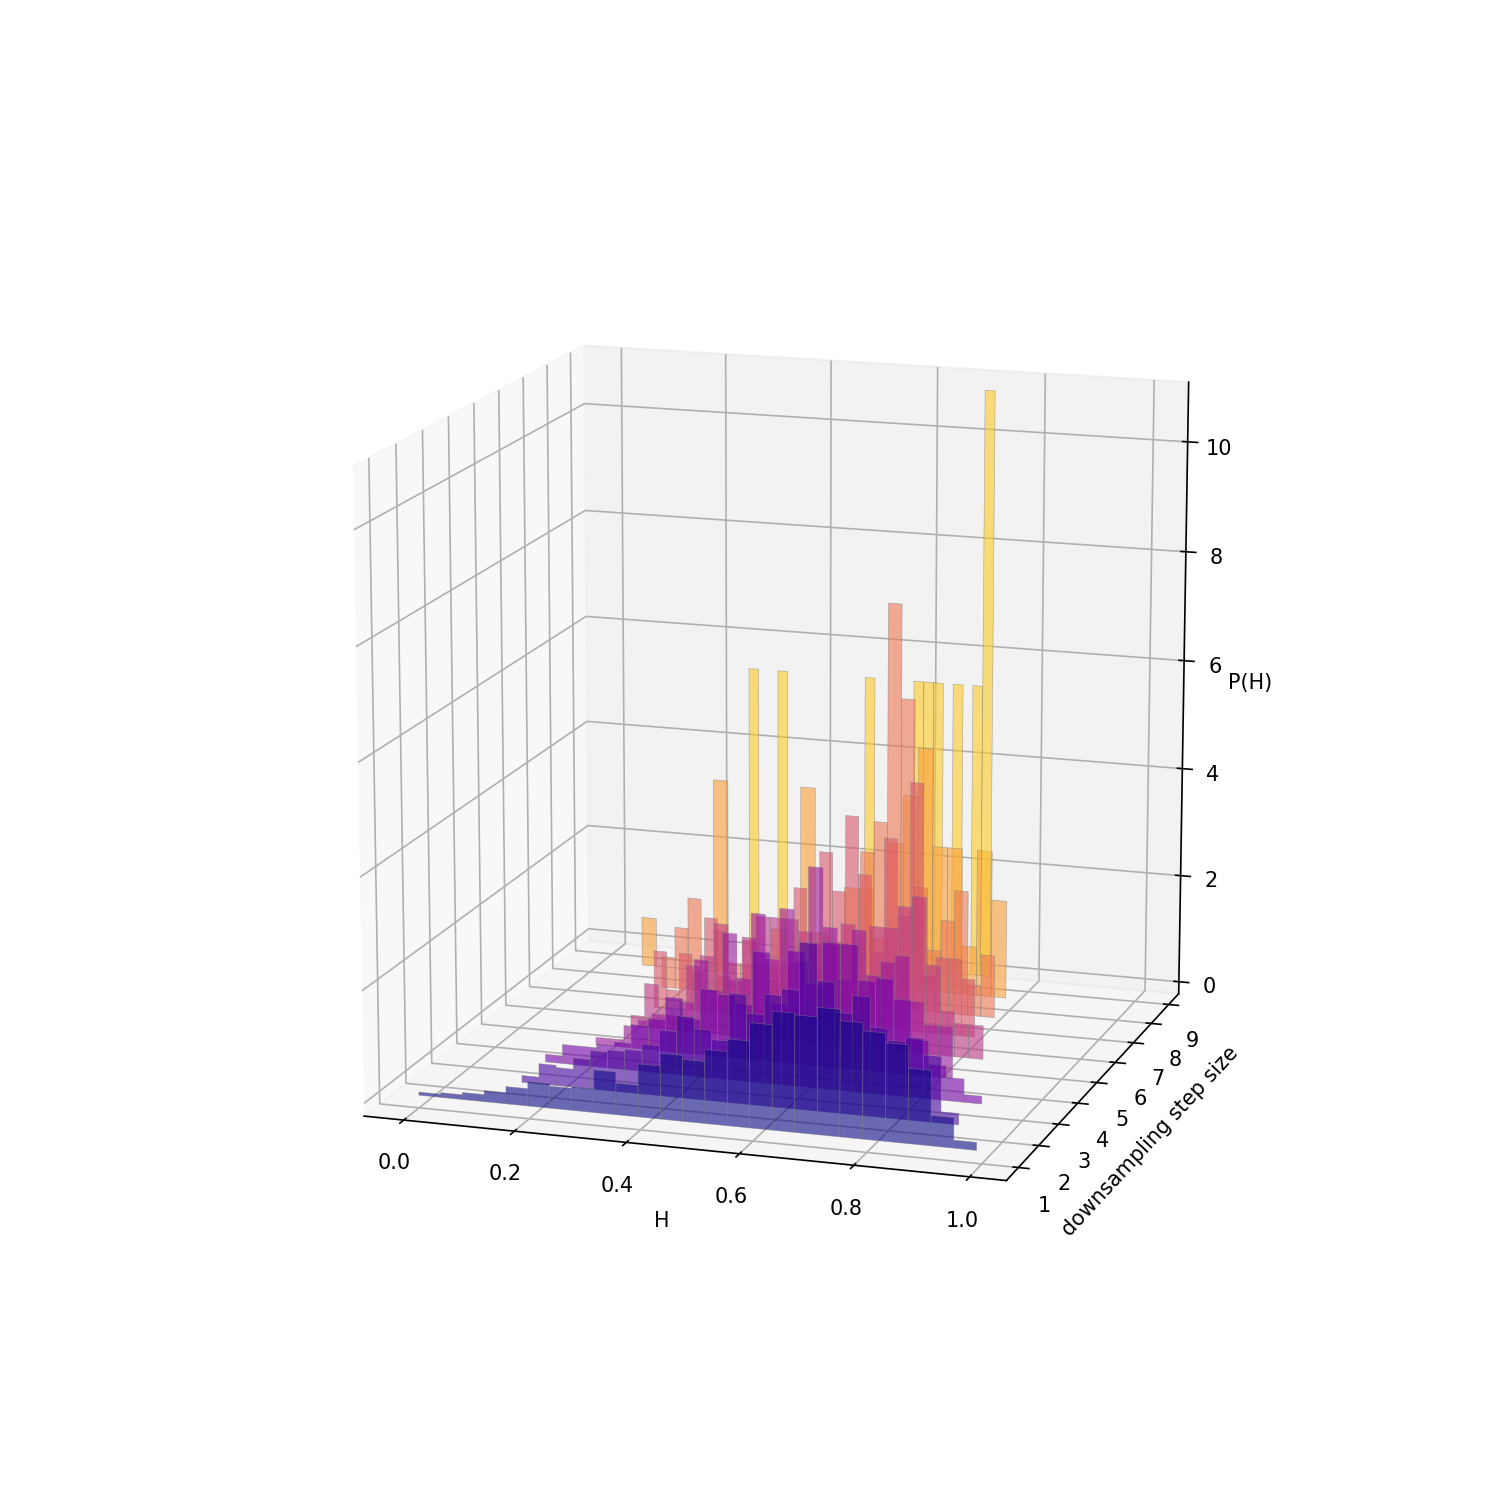

In [11]:
def plot_3d(h_dict,n_bins):
    
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.plasma
    
    steps = [int(s) for s in list(h_dict)]
    yticks = np.array(steps)
    
    norm_counts, bins = get_hist_h(h_dict,n_bins)

    for i,_ in enumerate(steps):
        ytick = yticks[i]
        temp_counts = norm_counts[i]
        temp_bins = bins[i]
        xcenter = np.convolve(temp_bins, np.ones(2), "valid")/2
        xwidth = np.diff(temp_bins)
        ax.bar(left=xcenter, height=temp_counts, width=xwidth, zs=ytick,
               zdir="y", color=cmap(i/len(yticks)), alpha=0.6, edgecolor="grey", linewidth=0.3)
       

    ax.set_xlabel("H")
    ax.set_ylabel("downsampling step size")
    ax.set_zlabel("P(H)")

    ax.set_yticks(yticks)
    plt.show()
    
    return norm_counts,bins
    
norm_counts,bins = plot_3d(h_dict,25)

In [19]:
def plot_hist_2D(data, step_sizes, nbins, window):
    """
    
    """
    track_id_values = np.unique(data['TrackID'])
    
    # plot histogram for each downsampling step size
    for s in step_sizes:
        # compute H values for each track and put them all in one array
        h = np.array([])
        for tid in track_id_values:
            track_data = data[data['TrackID']==tid]
            h_arr, ht_arr = dsample_est_hurst(track_data, s, window)  
            # h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)  
            h = np.append(h, np.ravel(h_arr))
        plt.hist(h, nbins, density=True, label='step size = {}'.format(s))  
        # density=True for normalisation so that area under histogram integrates to 1
    plt.legend()
    plt.xlabel('H')
    plt.ylabel('p(H)')
    plt.show()
        

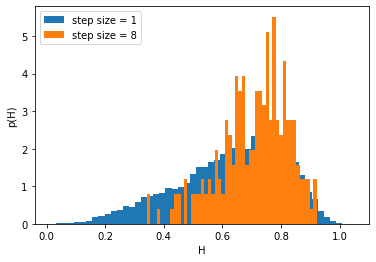

In [136]:
nbins = 50
plot_hist_2D(data, [1, 8], nbins, window)

In [ ]:
h2,ht2 = dsample_est_hurst(data,2, window)

In [45]:
h3,ht3 = dsample_est_hurst(data,3, window)

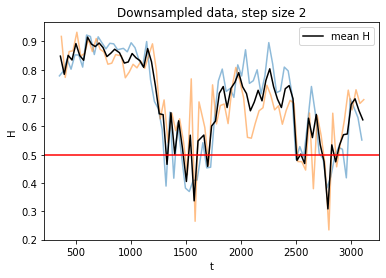

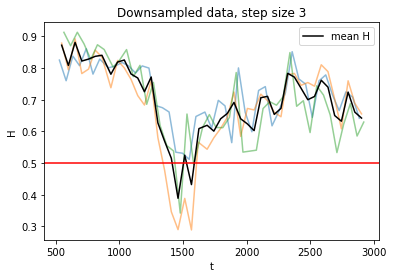

In [46]:
def plot_downsampled_hurst(h_arr, ht_arr):
    """
    """
    h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    
    for i in np.arange(len(h_arr)):
        plt.plot(ht_arr[i], h_arr[i], alpha=0.5)
    plt.plot(ht_av_arr, h_av_arr, label='mean H', color='k')
    plt.axhline(0.5, c='r')
    plt.xlabel('t')
    plt.ylabel('H')
    plt.title('Downsampled data, step size {}'.format(len(h_arr)))
    plt.legend()
    plt.show()
    
plot_downsampled_hurst(h2, ht2)
plot_downsampled_hurst(h3, ht3)

### 3D histogram

3D histogram:<br>
x axis is H.<br>
y axis is step size used for that downsampled data set.<br>
z axis is normalised average counts.<br>

In [51]:
def get_3D_hist_data(data_in, step_sizes, nbins, window):
    """
    Args:
        data_in: pandas dataframe
        step_sizes: array of int
        nbins: int, number of histogram bins
    Returns:
        normalised_counts_all: 2D np array, each row is normalised average counts for a given step size
        bins_all: 2D np array, each row is bin edges for a given step size
    """
    normalised_counts_all = np.empty((len(step_sizes), nbins))
    bins_all = np.empty((len(step_sizes), nbins+1))
    
    for i, s in enumerate(step_sizes):
        h_arr, ht_arr = dsample_est_hurst(data_in, s, window)
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
        counts, bins = np.histogram(h_av_arr, nbins)
        normalised_counts = counts/len(h_av_arr)
        normalised_counts_all[i] = normalised_counts
        bins_all[i] = bins
        
    return normalised_counts_all, bins_all

In [54]:
nbins = 50
hist = get_3D_hist_data(data, step_sizes, nbins, window)

ValueError: negative dimensions are not allowed

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

cmap = plt.cm.plasma

yticks = np.array(step_sizes)

for i, s in enumerate(step_sizes):
    ytick = yticks[i]
    normalised_counts = hist[0][i]
    bins = hist[1][i]
    xcenter = np.convolve(bins, np.ones(2), "valid")/2
    xwidth = np.diff(bins)
    ax.bar(left=xcenter, height=normalised_counts, width=xwidth, zs=ytick,
           zdir="y", color=cmap(i/len(yticks)), alpha=0.6, edgecolor="grey", linewidth=0.3)
    
ax.set_xlabel("H")
ax.set_ylabel("downsampling step size")
ax.set_zlabel("P(H)")

ax.set_yticks(yticks)
plt.show()

### Gaussian mixture model

<IPython.core.display.Javascript object>


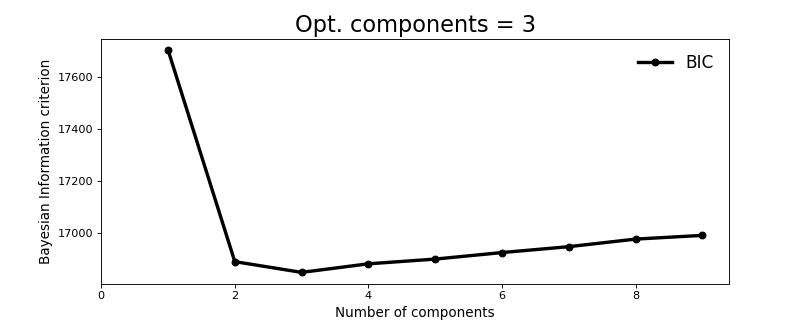

<IPython.core.display.Javascript object>


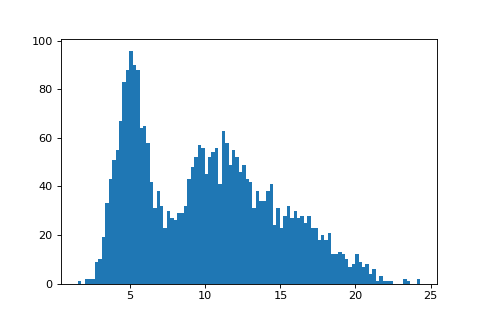

In [106]:
# first of all, let's confirm the optimal number of components
def optimum_components(data,n_max,plot=0):
    bics = []
    min_bic = 0
    counter=1
    for i in range (n_max-1): # test the AIC/BIC metric between 1 and 10 components
        gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
        labels = gmm.fit(data).predict(data)
        bic = gmm.bic(data)
        bics.append(bic)
        if bic < min_bic or min_bic == 0:
            min_bic = bic
            opt_bic = counter
        counter +=1
    
    if plot==1:    
        fig,ax = plt.subplots(figsize=(10, 4))
        # Plot 1
        plt.plot(np.arange(1,n_max), bics, 'o-', lw=3, c='black', label='BIC')
        plt.legend(frameon=False, fontsize=15)
        plt.xlabel('Number of components', fontsize=12)
        plt.ylabel('Bayesian Information criterion', fontsize=12)
        plt.xticks(np.arange(0,n_max, 2))
        plt.title('Opt. components = '+str(opt_bic), fontsize=20)
        plt.show()

        
    return opt_bic,bics

data_temp = np.concatenate((np.random.normal(5, 1, 1000), np.random.normal(10, 2, 1000),np.random.normal(15, 3, 1000)))
data_temp = data_temp.reshape(-1, 1)   #hist[1][1].reshape(-1,1)
n_optimum,bic_vals = optimum_components(data_temp,10,plot=1)

fig,ax = plt.subplots()
plt.hist(data_temp,100)
plt.show()

<IPython.core.display.Javascript object>


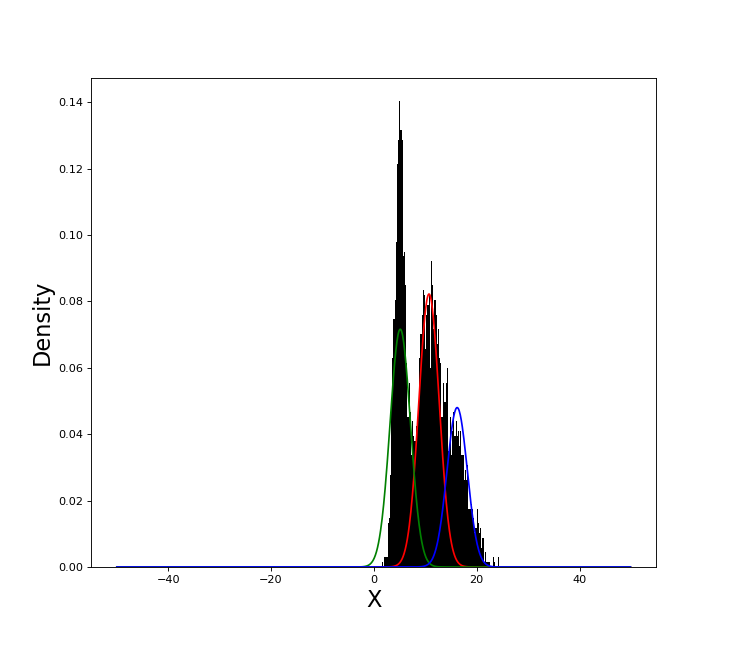

In [107]:
# create GMM model object
gmm = GMM(n_components = n_optimum, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(data_temp).means_  
covs  = gmm.fit(data_temp).covariances_
weights = gmm.fit(data_temp).weights_

x_axis = np.arange(-50, 50, 0.1)

# create necessary things to plot
g1 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
g2 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[0][0][0])))*weights[1] # 1st gaussian
g3 = norm.pdf(x_axis, float(mean[2][0]), np.sqrt(float(covs[0][0][0])))*weights[2] # 1st gaussian

fig,ax = plt.subplots(figsize=(9,8))
# Plot 2
plt.hist(data_temp, density=True, color='black',bins=100)
plt.plot(x_axis, g1, c='r')
plt.plot(x_axis, g2, c='g')
plt.plot(x_axis, g3, c='b')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.show()

## Meeting with Dr. Waigh 20/10/2022

Notes before meeting:
- Produced histograms of P(H) vs H for different downsampling steps
- Plotted in 3D, shows tendency to unimodal distribution, with high H , for high downsampling
- Displays trend to more directed behaviour
- Established code to find gaussian mixtures 

Next: 
- Upscale to treat full cohort of data, maybe average across for better stats?
- Finalise gaussian mixture and use with our data/3d plots

Questions:
- should we average displacement or H
- why would the histograms be different, training? 
- CNNS? wavenet?
- more detailed considerations, like sinusoidal fractal component and contact inhibition?

----------------------------------------------------------------------------------------------

Feedback:
- increase bin size, 2x bigger 
- count and normalise, not mean, area must be one overall
- plotting the tracks in 3D
- do with different mutants 
- look into normalisation for histograms 
- quantify differences when using model with code (CPU vs GPU)
- feature engineering issues , models fit scaling exponenent and alpha 
- haemocyte data 

Ideas: 
- Waigh mentioned developing models to account for what we observe, (sampling) time dependency of the P(h) distributions
- Trying to extend gaussian mixtures but for non-gaussian distributions, BIC over a wider model space?
- Machine learning for alpha and d-alpha 

Work plan: 
- Displacement 3D (Mila)
- Change normalisation and describe in markdown (Mila)
- Gaussian Mixture model applied to endosome data , not just example data ( Paul ) 
- Change to have just 2d histograms, perhaps 1, 3, 5,7,9,11  steps (Mila)
- Read in haemocuyte data and apply existing code
    - work on it together 20.10
    - contact t. millard about the track IDs and general structure of haemocyte data + mutant data set 
    

## Meeting Dr waigh 26.10

To do beforehand:
- Both need to run analysis on steps of 1 to 10, for wild, lanb1, from all frames if time, MAKE SURE TO NOT RESTRICT DATA 
- Paul: window size of 12
- Mila: window size of 20

### Notes before 
General update
- adapted endosome analysis code for haemocyte data, taking into account the different tracks
- wrote code to save data for downsampling in a dictionary format, txt file
- gaussian mixture analysis extended but no progress, will be developed more later potentially
- produced 3D plots for wild, lanB1
- plots for different window size 



Questions
- We want to reduce the window so that we don't have to lose so many tracks, is there motivation to have 20 rather than 15? ( machine learning model width?)
- Because of greater downsampled data having less data, they become noisier, is there a way to resolve this? 
- Do we expect the distribution to become narrower?
- should we be fixing the bin width or the bin number?
- Should we average the different downsampling runs or simply add all the different runs into the hitsogram that will get normalised? we are wondering if this would negate the reduced tracks for higher downsampling
- Seemed to get very different histograms for different window sizes, is this reasonable? 



## Scrap

In [ ]:
"""
def get_hht_avg_dict(data_in, step_sizes):
    """
    """
    h_av_dict = {}
    #ht_av_dict = {}
    
    for i, s in enumerate(step_sizes):
        h_arr, ht_arr = dsample_est_hurst(data_in, s)
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    
        h_av_dict["{}".format(s)] = h_av_arr.tolist()
     #   ht_av_dict["{}".format(s)] = ht_av_arr.tolist()
        
    return h_av_dict#, ht_av_dict
    
    
def save_hht_data(h_avg_data,ht_avg_data):
    """
    """
    with open('h_avg_file.txt', 'w') as h_avg_file:
        h_avg_file.write(json.dumps(h_avg_data))
        
    with open('ht_avg_file.txt', 'w') as ht_avg_file:
        ht_avg_file.write(json.dumps(ht_avg_data))
        
"""

agent based model  - exponent time scale varying / length scale varying

shirt: internal dynamics of cell
long: geometry of maze ?

next: simulate anomalous transport, fbm, varying H(t)

multifractal, 
compound process, random H - maths more complicated
fbm is random process - can randomise parameter

discrete change in H (dan) - don't know H at transition point (issue with memory)
simulate continuously varying H - either fn H is deterministic (define by other fn) or stochastic

fbm is generalisation of brownian
- has memory
- can calculate fractal dimension (2-2H) for fbm trajectory - a number - can associate single number of fractal dimention with fbm trajectory

multifractal
- one part of trajectory has one fractal dimension, another has other
- have function to describe fractal dimension - could change with time/space

next week meeting at thursday 3pm 3/11/2022